=======================================
Visualizing the stock market structure
=======================================

This example employs several unsupervised learning techniques to extract
the stock market structure from variations in historical quotes.

The quantity that we use is the daily variation in quote price: quotes
that are linked tend to cofluctuate during a day.

.. _stock_market:

Learning a graph structure
--------------------------

We use sparse inverse covariance estimation to find which quotes are
correlated conditionally on the others. Specifically, sparse inverse
covariance gives us a graph, that is a list of connection. For each
symbol, the symbols that it is connected too are those useful to explain
its fluctuations.

Clustering
----------

We use clustering to group together quotes that behave similarly. Here,
amongst the :ref:`various clustering techniques <clustering>` available
in the scikit-learn, we use :ref:`affinity_propagation` as it does
not enforce equal-size clusters, and it can choose automatically the
number of clusters from the data.

Note that this gives us a different indication than the graph, as the
graph reflects conditional relations between variables, while the
clustering reflects marginal properties: variables clustered together can
be considered as having a similar impact at the level of the full stock
market.

Embedding in 2D space
---------------------

For visualization purposes, we need to lay out the different symbols on a
2D canvas. For this we use :ref:`manifold` techniques to retrieve 2D
embedding.


Visualization
-------------

The output of the 3 models are combined in a 2D graph where nodes
represents the stocks and edges the:

- cluster labels are used to define the color of the nodes
- the sparse covariance model is used to display the strength of the edges
- the 2D embedding is used to position the nodes in the plan

This example has a fair amount of visualization-related code, as
visualization is crucial here to display the graph. One of the challenge
is to position the labels minimizing overlap. For this we use an
heuristic based on the direction of the nearest neighbor along each

## Loading Functions

In [1]:
import pandas as pd
import datetime
%matplotlib inline
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
try:
    from matplotlib.finance import quotes_historical_yahoo
except ImportError:
    from matplotlib.finance import quotes_historical_yahoo_ochl as quotes_historical_yahoo
from matplotlib.collections import LineCollection

from sklearn import cluster, covariance, manifold
from __future__ import division
###############################################################################
# Retrieve the data from Internet

## Reading Companies list

In [2]:
sp100 = pd.read_csv('iShares-SP-100-ETF_fund.csv')

In [3]:
sp100

,Ticker,Name,Asset Class,Weight (%),Price,Shares,Market Value,Notional Value,Sector,SEDOL,ISIN,Exchange
0,AMZN,AMAZON COM INC,Equity,2.07,620.75,"153,143.00","95,063,517.25","95,063,517.25",Consumer Discretionary,"2,000,019.00",US0231351067,NASDAQ
1,CMCSA,COMCAST A CORP,Equity,1.30,61.84,"964,818.00","59,664,345.12","59,664,345.12",Consumer Discretionary,"2,044,545.00",US20030N1019,NASDAQ
2,DIS,WALT DISNEY,Equity,1.28,98.63,"595,261.00","58,710,592.43","58,710,592.43",Consumer Discretionary,"2,270,726.00",US2546871060,New York Stock Exchange Inc.
3,F,F MOTOR,Equity,0.44,13.09,"1,547,094.00","20,251,460.46","20,251,460.46",Consumer Discretionary,"2,615,468.00",US3453708600,New York Stock Exchange Inc.
4,FOX,TWENTY-FIRST CENTURY FOX INC CLASS,Equity,0.11,29.79,"170,200.00","5,070,258.00","5,070,258.00",Consumer Discretionary,BBM4S80,US90130A2006,NASDAQ
5,FOXA,TWENTY FIRST CENTURY FOX INC CLASS,Equity,0.29,29.85,"444,189.00","13,259,041.65","13,259,041.65",Consumer Discretionary,BBM4S68,US90130A1016,NASDAQ
6,GM,GENERAL MOTORS,Equity,0.37,30.72,"557,732.00","17,133,527.04","17,133,527.04",Consumer Discretionary,B665KZ5,US37045V1008,New York Stock Exchange Inc.
7,HD,HOME DEPOT INC,Equity,1.47,134.37,"502,836.00","67,566,073.32","67,566,073.32",Consumer Discretionary,"2,434,209.00",US4370761029,New York Stock Exchange Inc.
8,LOW,LOWES COMPANIES INC,Equity,0.61,76.5,"363,141.00","27,780,286.50","27,780,286.50",Consumer Discretionary,"2,536,763.00",US5486611073,New York Stock Exchange Inc.
9,MCD,MCDONALDS CORP,Equity,0.99,127.51,"357,782.00","45,620,782.82","45,620,782.82",Consumer Discretionary,"2,550,707.00",US5801351017,New York Stock Exchange Inc.


Initialized 

## Functions that return the labels of clustering

In [4]:
def settime(startY, startM, endY, endM):
    d1 = datetime.datetime(startY, startM, 1)
    d2 = datetime.datetime(endY, endM, 1)
    symbols = np.array(sp100['Ticker'])
    names = np.array(sp100['Name'])
    quotes = [quotes_historical_yahoo(symbol, d1, d2, asobject=True)
              for symbol in symbols]
    open = np.array([q.open for q in quotes]).astype(np.float)
    close = np.array([q.close for q in quotes]).astype(np.float)
    # The daily variations of the quotes are what carry most information
    variation = close - open
    ###############################################################################
    # Learn a graphical structure from the correlations
    edge_model = covariance.GraphLassoCV()
    # standardize the time series: using correlations rather than covariance
    # is more efficient for structure recovery
    X = variation.copy().T
    X /= X.std(axis=0)
    edge_model.fit(X)
    ###############################################################################
    # Cluster using affinity propagation
    _, labels = cluster.affinity_propagation(edge_model.covariance_)
    n_labels = labels.max()
    l1 = []
    for i in range(n_labels + 1):
        l1.append(names[labels == i])
    return labels  

In [5]:
def dataframe(startY, startM, endY, endM):
    d1 = datetime.datetime(startY, startM, 1)
    d2 = datetime.datetime(endY, endM, 1)
    symbols = np.array(sp100['Ticker'])
    names = np.array(sp100['Name'])
    quotes = [quotes_historical_yahoo(symbol, d1, d2, asobject=True)
              for symbol in symbols]
    open = np.array([q.open for q in quotes]).astype(np.float)
    close = np.array([q.close for q in quotes]).astype(np.float)
    # The daily variations of the quotes are what carry most information
    variation = close - open
    ###############################################################################
    # Learn a graphical structure from the correlations
    edge_model = covariance.GraphLassoCV()
    # standardize the time series: using correlations rather than covariance
    # is more efficient for structure recovery
    X = variation.copy().T
    X /= X.std(axis=0)
    edge_model.fit(X)
    ###############################################################################
    # Cluster using affinity propagation
    _, labels = cluster.affinity_propagation(edge_model.covariance_)
    n_labels = labels.max()
    l1 = []
    for i in range(n_labels + 1):
        l1.append(symbols[labels == i])
    return l1

## Function return the standardized correlation of stocks over time

In [6]:
def outprice(startY, startM, endY, endM):
    d1 = datetime.datetime(startY, startM, 1)
    d2 = datetime.datetime(endY, endM, 1)
    symbols = np.array(sp100['Ticker'][:10])# choose stocks
    names = np.array(sp100['Name'])
    quotes = [quotes_historical_yahoo(symbol, d1, d2, asobject=True)
              for symbol in symbols]
    open = np.array([q.open for q in quotes]).astype(np.float)
    close = np.array([q.close for q in quotes]).astype(np.float)
    # The daily variations of the quotes are what carry most information
    variation = close - open
    ###############################################################################
    # Learn a graphical structure from the correlations
    edge_model = covariance.GraphLassoCV()
    # standardize the time series: using correlations rather than covariance
    # is more efficient for structure recovery
    X = variation.copy().T
    X /= X.std(axis=0)
    return X

## Plot of correlation for first 10 stocks from March 2016 to Aprill 2016

/Applications/anaconda/lib/python2.7/site-packages/matplotlib/finance.py:485: MatplotlibDeprecationWarning: This function has been deprecated in 1.4 in favor of `quotes_historical_yahoo_ochl`, which maintains the original argument order, or `quotes_historical_yahoo_ohlc`, which uses the open-high-low-close order. This function will be removed in 1.5
  mplDeprecation)


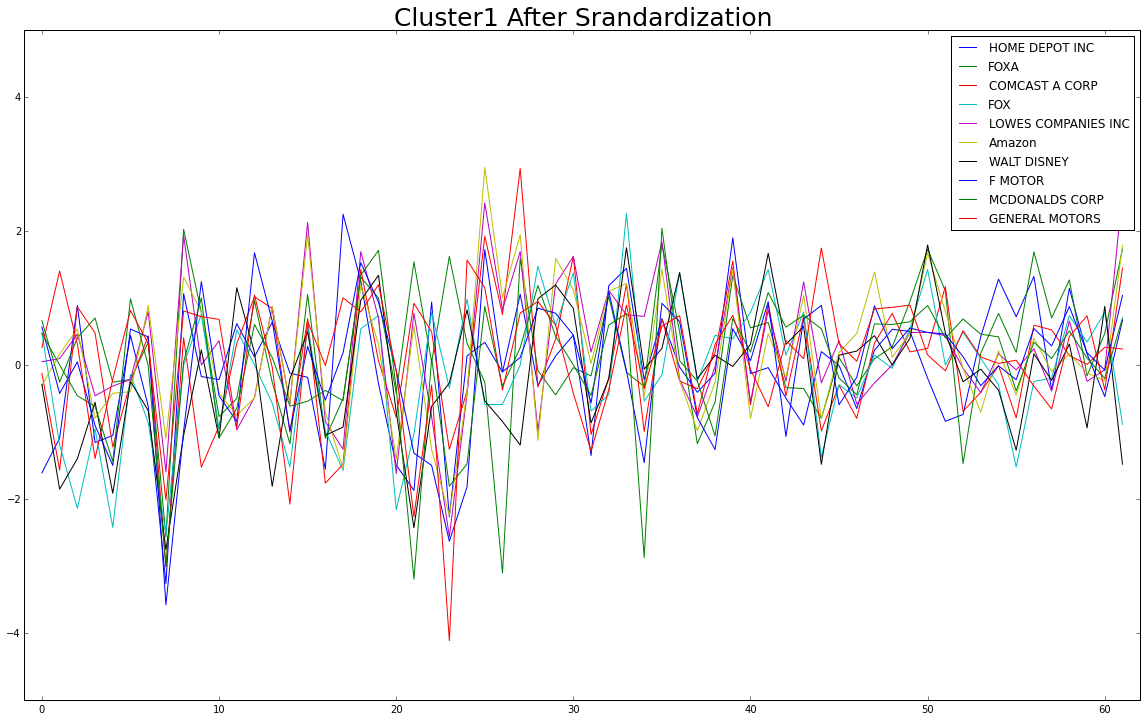

In [7]:
fig = plt.figure(figsize=(20,12))
plt.plot(outprice(2016,1,2016,4))
plt.axis([-1, 62, -5, 5]) 
plt.title('Cluster1 After Srandardization', fontsize=25)
plt.legend({'Amazon','COMCAST A CORP','WALT DISNEY','F MOTOR','FOX','FOXA','GENERAL MOTORS','HOME DEPOT INC','LOWES COMPANIES INC','MCDONALDS CORP'})


## get score of Pred and True

In [8]:
pred = settime(2013,1,2016,1)
true = settime(2016,1,2016,4)
preddf = dataframe(2013,1,2016,1)
truedf = dataframe(2016,1,2016,4)

In [ ]:
def getscore(pred,true):   
    score = 0
    for a in range(len(pred)):
        for b in range(len(true)):
            if (a!=b) & (pred[a] == pred[b]) & (true[a] == true[b]):
                score += 1
    return score

In [10]:
score = getscore(pred,true)/getscore(true,true)

In [11]:
print score

0.506578947368


#The original stock plot (Taking Cluster1 as an example):

In [12]:
#the cluster that the first stock belongs to:
cluster10 = preddf[10]
cluster10

array(['AMZN', 'MCD', 'PCLN', 'MA', 'MSFT', 'V'], dtype=object)

/Applications/anaconda/lib/python2.7/site-packages/matplotlib/finance.py:865: MatplotlibDeprecationWarning:

This function has been deprecated in 1.4 in favor of `candlestick_ochl`, which maintains the original argument order, or `candlestick_ohlc`, which uses the open-high-low-close order. This function will be removed in 1.5



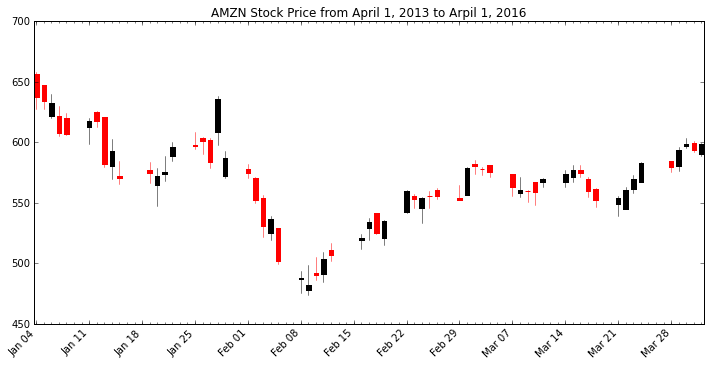

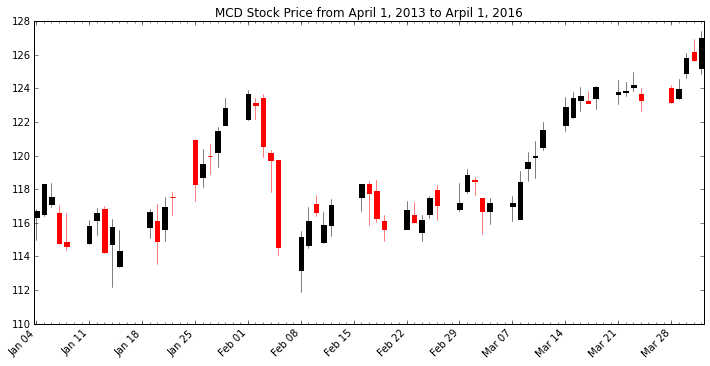

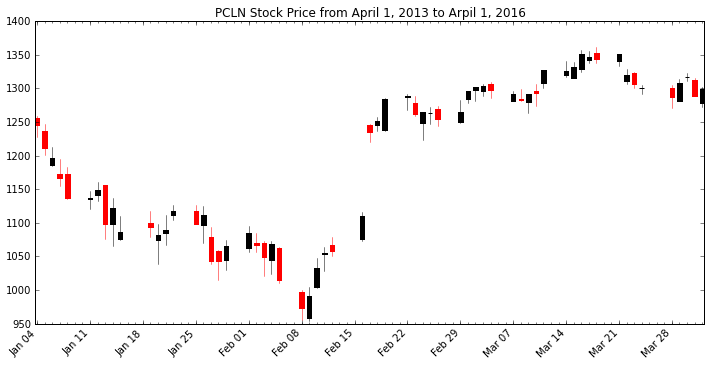

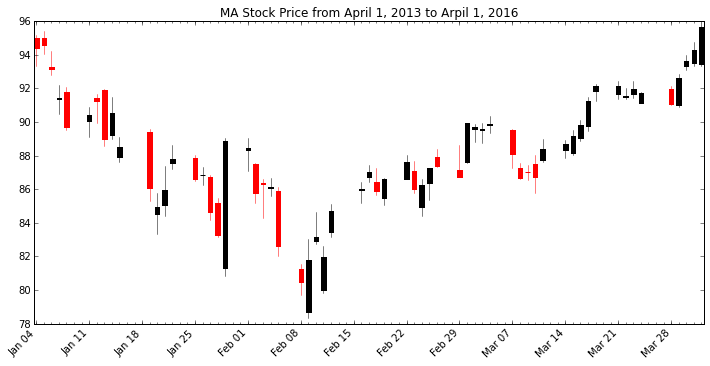

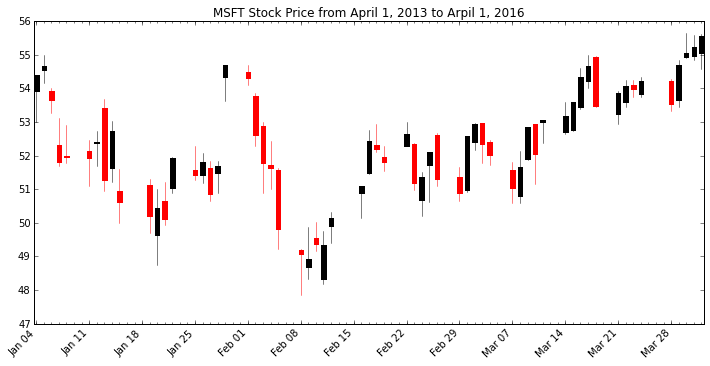

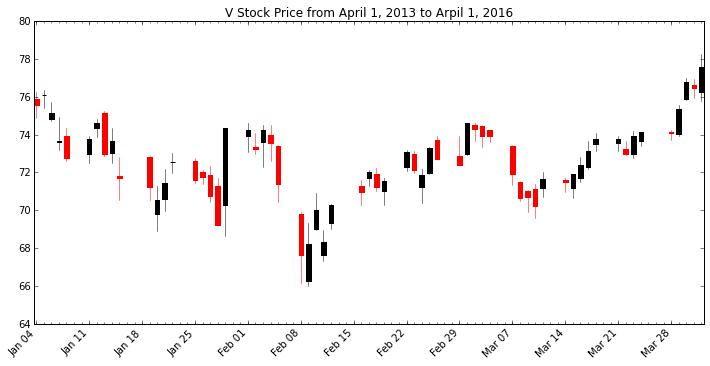

In [15]:
from pylab import *
from matplotlib.dates import  DateFormatter, WeekdayLocator, HourLocator, DayLocator, MONDAY
from matplotlib.finance import quotes_historical_yahoo, candlestick, plot_day_summary, candlestick2
import plotly.plotly as py
from plotly.tools import FigureFactory as FF

# (Year, month, day) tuples suffice as args for quotes_historical_yahoo
date1 = ( 2016, 1, 1)
date2 = ( 2016, 4, 1)

mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
alldays    = DayLocator()              # minor ticks on the days
weekFormatter = DateFormatter('%b %d')  # Eg, Jan 12
dayFormatter = DateFormatter('%d')      # Eg, 12


mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
alldays    = DayLocator()              # minor ticks on the days
weekFormatter = DateFormatter('%b %d')  # Eg, Jan 12
dayFormatter = DateFormatter('%d')      # Eg, 12


for i in range (6):
    quotes = quotes_historical_yahoo(cluster10[i], date1, date2)
    if len(quotes) == 0:
        raise SystemExit
    fig = plt.figure(figsize=(12,6))
    fig.subplots_adjust(bottom=0.2)
    ax = fig.add_subplot(111)
    ax.xaxis.set_major_locator(mondays)
    ax.xaxis.set_minor_locator(alldays)
    ax.xaxis.set_major_formatter(weekFormatter)
    #ax.xaxis.set_minor_formatter(dayFormatter)
    #plot_day_summary(ax, quotes, ticksize=3)
    candlestick(ax, quotes, width=0.6)
    ax.xaxis_date()
    ax.set_title( cluster10[i] + ' Stock Price from April 1, 2013 to Arpil 1, 2016')
    ax.autoscale_view()
    setp(gca().get_xticklabels(), rotation=45, horizontalalignment='right')
show()

#The fisrt cluster Plot after standardization (using the previous 3-month data):

In [16]:
np.where(pred == 10)

(array([ 0,  9, 11, 83, 84, 88]),)

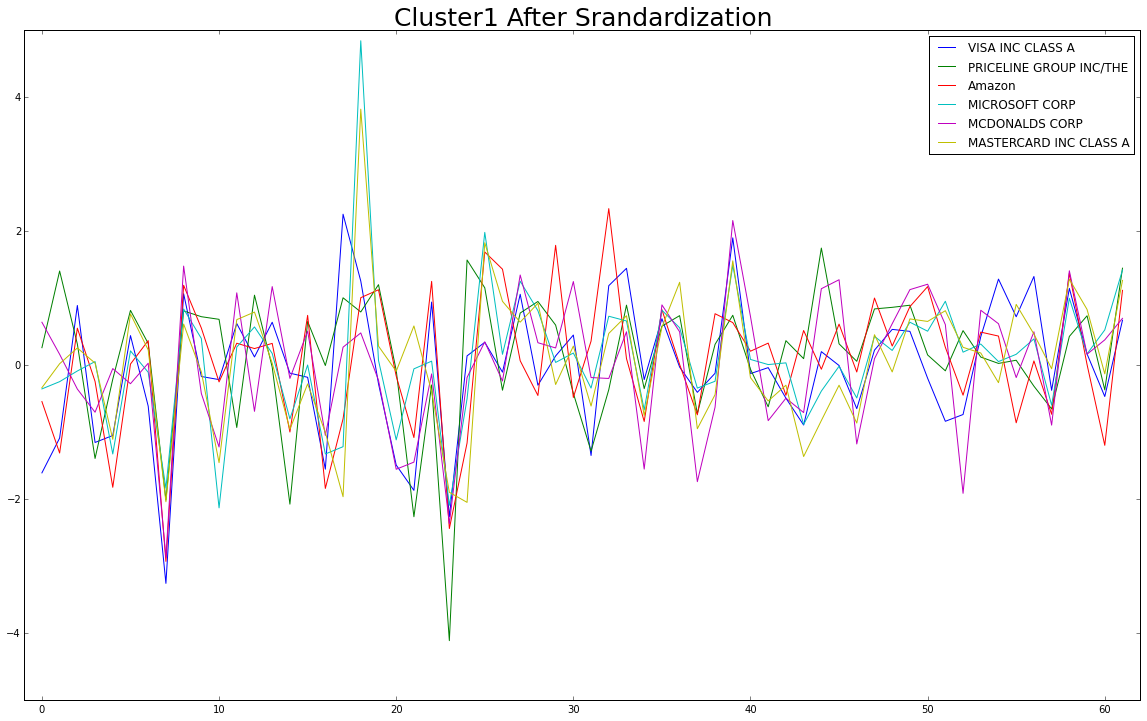

In [19]:
import matplotlib.pyplot as plt
d1 = (2016, 1, 1)
d2 = (2016, 4, 1)
symbols = cluster10# choose the first cluster stocks
quotes = [quotes_historical_yahoo(symbol, d1, d2, asobject=True)
            for symbol in cluster10]
open = np.array([q.open for q in quotes]).astype(np.float)
close = np.array([q.close for q in quotes]).astype(np.float)
# The daily variations of the quotes are what carry most information
variation = close - open
###############################################################################
# Learn a graphical structure from the correlations
edge_model = covariance.GraphLassoCV()
# standardize the time series: using correlations rather than covariance
# is more efficient for structure recovery
X = variation.copy().T
X /= X.std(axis=0)
fig = plt.figure(figsize=(20,12))
plt.axis([-1, 62, -5, 5]) 
plt.plot(X)
plt.title('Cluster1 After Srandardization', fontsize=25)
plt.legend({'Amazon','MCDONALDS CORP','PRICELINE GROUP INC/THE','MASTERCARD INC CLASS A','MICROSOFT CORP','VISA INC CLASS A'})


Compare two plots before clustering and after cluster

## Function that finds companies been clustered the same over pred and true

In [20]:
def samecom(pred,true):
    lst = set()
    names = np.array(sp100['Name'])
    sects = np.array(sp100['Sector'])
    for a in range(len(pred)):
        for b in range(len(true)):
            if (a!=b) & (pred[a] == pred[b]) & (true[a] == true[b]):
                lst.add((names[a],sects[a]))
                lst.add((names[b],sects[b]))
    return lst                      

In [21]:
samecom(settime(2015,1,2016,1),settime(2016,1,2016,4)) #companies that are clustered the same over

{('3M CO', 'Industrials'),
 ('ABBVIE INC', 'Health Care'),
 ('ALLERGAN', 'Health Care'),
 ('ALTRIA GROUP INC', 'Consumer Staples'),
 ('AMAZON COM INC', 'Consumer Discretionary'),
 ('AMGEN INC', 'Health Care'),
 ('BANK OF AMERICA CORP', 'Financials'),
 ('BANK OF NEW YORK MELLON CORP', 'Financials'),
 ('BERKSHIRE HATHAWAY INC CLASS B', 'Financials'),
 ('BIOGEN INC', 'Health Care'),
 ('BLACKROCK INC.', 'Financials'),
 ('BOEING', 'Industrials'),
 ('BRISTOL MYERS SQUIBB', 'Health Care'),
 ('CAPITAL ONE FINANCIAL CORP', 'Financials'),
 ('CATERPILLAR INC', 'Industrials'),
 ('CELGENE CORP', 'Health Care'),
 ('CHEVRON CORP', 'Energy'),
 ('CISCO SYSTEMS INC', 'Information Technology'),
 ('CITIGROUP INC', 'Financials'),
 ('COCA-COLA', 'Consumer Staples'),
 ('COLGATE-PALMOLIVE', 'Consumer Staples'),
 ('CONOCOPHILLIPS', 'Energy'),
 ('DANAHER CORP', 'Industrials'),
 ('DUKE ENERGY CORP', 'Utilities'),
 ('ELI LILLY', 'Health Care'),
 ('EMC CORP', 'Information Technology'),
 ('EMERSON ELECTRIC', 'Indus

## Find companies clustered together and their sectors

In [22]:
samcom = samecom(settime(2015,1,2016,1),settime(2016,1,2016,4)) 

In [23]:
lst = []
for i in samcom:
    lst.append(i[1])

In [24]:
Counter(lst) # count the sectors that are still clustered together

Counter({'Industrials': 13, 'Financials': 12, 'Health Care': 11, 'Consumer Discretionary': 10, 'Information Technology': 9, 'Energy': 7, 'Consumer Staples': 6, 'Utilities': 4, 'Materials': 1})

In [25]:
Counter(np.array(sp100['Sector'])) #total sectors by count

Counter({'Consumer Discretionary': 15, 'Financials': 15, 'Industrials': 14, 'Health Care': 14, 'Information Technology': 13, 'Consumer Staples': 11, 'Energy': 7, 'Utilities': 4, 'Materials': 3, 'Telecommunications': 2})

###  <font color='red'>some thing we find from two counters ......</font> 


## Accuracy score by using the previous clustering to predict the future clustering over time

In [40]:
def trueM(i,j):    
    score = []
    true = settime(2016,i,2016,j) 
    for a in range(2013, 2016):#loop over 2013 to 2016
        for b in range(1,13):
            pred = settime(a,b,2016,1)
            percent = getscore(pred,true)/getscore(true,true)
            score.append(percent)    
    score.reverse()  
    return score

In [41]:
trueM(1,4)

[0.2565789473684211,
 0.3815789473684211,
 0.4144736842105263,
 0.3684210526315789,
 0.4375,
 0.4342105263157895,
 0.4440789473684211,
 0.4342105263157895,
 0.45394736842105265,
 0.4375,
 0.48355263157894735,
 0.5230263157894737,
 0.5098684210526315,
 0.46710526315789475,
 0.4868421052631579,
 0.506578947368421,
 0.48355263157894735,
 0.5493421052631579,
 0.47039473684210525,
 0.47039473684210525,
 0.5657894736842105,
 0.5263157894736842,
 0.4901315789473684,
 0.5427631578947368,
 0.5230263157894737,
 0.5230263157894737,
 0.5328947368421053,
 0.5361842105263158,
 0.506578947368421,
 0.5032894736842105,
 0.506578947368421,
 0.5032894736842105,
 0.5098684210526315,
 0.506578947368421,
 0.506578947368421,
 0.506578947368421]

In [ ]:
trueM(1,2)

In [ ]:
trueM(2,3)

In [ ]:
trueM(3,4)

In [ ]:
trueM(1,3)

## plot of the accruacy over time

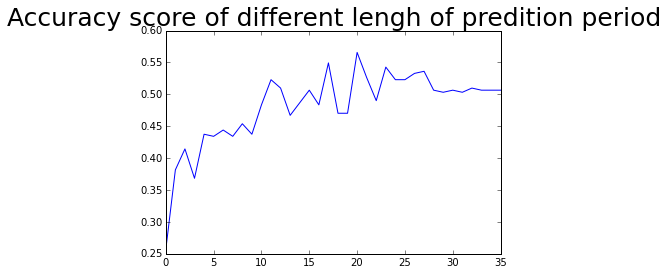

In [45]:
plt.plot(trueM(1,4))
plt.title('Accuracy score of different lengh of predition period', fontsize=10)

In [31]:
def maxmonth():
    max_month = []
    for i in range(1,4):
        score = []
        true = settime(2016,i,2016,i+1)
        for a in range(2013,2016):
            for b in range(1,13):
                predicted = settime(a,b,2016,i)
                percent = getscore(predicted, true) / getscore(true, true)
                score.append(percent)
        score.reverse()
        score = np.array(score)
        maxmonth = np.where(score == max(score))
        score = list(score)
        max_month.append(maxmonth)
    print max_month

The result shows that 

## Plot the clustering on 2D 

In [51]:
# Choose a time period reasonnably calm (not too long ago so that we get
# high-tech firms, and before the 2008 crash)
d1 = datetime.datetime(2016, 1, 1)
d2 = datetime.datetime(2016, 4, 1)
symbols = np.array(sp100['Ticker'])
names = np.array(sp100['Name'])
quotes = [quotes_historical_yahoo(symbol, d1, d2, asobject=True)
          for symbol in symbols]
open = np.array([q.open for q in quotes]).astype(np.float)
close = np.array([q.close for q in quotes]).astype(np.float)

# The daily variations of the quotes are what carry most information
variation = close - open

###############################################################################
# Learn a graphical structure from the correlations
edge_model = covariance.GraphLassoCV()

# standardize the time series: using correlations rather than covariance
# is more efficient for structure recovery
X = variation.copy().T
X /= X.std(axis=0)
edge_model.fit(X)

###############################################################################
# Cluster using affinity propagation

_, labels = cluster.affinity_propagation(edge_model.covariance_)
n_labels = 21

l1 = []
for i in range(n_labels + 1):
    l1.append(names[labels == i])

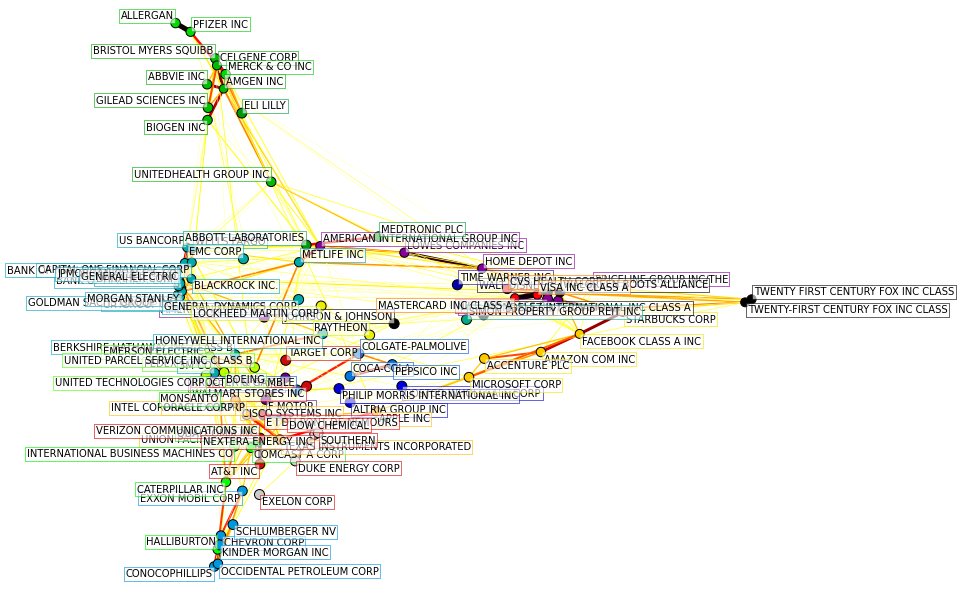

In [52]:
###############################################################################
# Find a low-dimension embedding for visualization: find the best position of
# the nodes (the stocks) on a 2D plane

# We use a dense eigen_solver to achieve reproducibility (arpack is
# initiated with random vectors that we don't control). In addition, we
# use a large number of neighbors to capture the large-scale structure.
node_position_model = manifold.LocallyLinearEmbedding(
    n_components=2, eigen_solver='dense', n_neighbors=6)

embedding = node_position_model.fit_transform(X.T).T

###############################################################################
# Visualization
plt.figure(1, facecolor='w', figsize=(10, 8))
plt.clf()
ax = plt.axes([0., 0., 1., 1.])
plt.axis('off')

# Display a graph of the partial correlations
partial_correlations = edge_model.precision_.copy()
d = 1 / np.sqrt(np.diag(partial_correlations))
partial_correlations *= d
partial_correlations *= d[:, np.newaxis]
non_zero = (np.abs(np.triu(partial_correlations, k=1)) > 0.02)

# Plot the nodes using the coordinates of our embedding
plt.scatter(embedding[0], embedding[1], s=100 * d ** 2, c=labels,
            cmap=plt.cm.spectral)

# Plot the edges
start_idx, end_idx = np.where(non_zero)
#a sequence of (*line0*, *line1*, *line2*), where::
#            linen = (x0, y0), (x1, y1), ... (xm, ym)
segments = [[embedding[:, start], embedding[:, stop]]
            for start, stop in zip(start_idx, end_idx)]
values = np.abs(partial_correlations[non_zero])
lc = LineCollection(segments,
                    zorder=0, cmap=plt.cm.hot_r,
                    norm=plt.Normalize(0, .7 * values.max()))
lc.set_array(values)
lc.set_linewidths(15 * values)
ax.add_collection(lc)

# Add a label to each node. The challenge here is that we want to
# position the labels to avoid overlap with other labels
for index, (name, label, (x, y)) in enumerate(
        zip(names, labels, embedding.T)):

    dx = x - embedding[0]
    dx[index] = 1
    dy = y - embedding[1]
    dy[index] = 1
    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]
    if this_dx > 0:
        horizontalalignment = 'left'
        x = x + .002
    else:
        horizontalalignment = 'right'
        x = x - .002
    if this_dy > 0:
        verticalalignment = 'bottom'
        y = y + .002
    else:
        verticalalignment = 'top'
        y = y - .002
    plt.text(x, y, name, size=10,
             horizontalalignment=horizontalalignment,
             verticalalignment=verticalalignment,
             bbox=dict(facecolor='w',
                       edgecolor=plt.cm.spectral(label / float(n_labels)),
                       alpha=.6))

plt.xlim(embedding[0].min() - .15 * embedding[0].ptp(),
         embedding[0].max() + .10 * embedding[0].ptp(),)
plt.ylim(embedding[1].min() - .03 * embedding[1].ptp(),
         embedding[1].max() + .03 * embedding[1].ptp())

plt.show()